In [1]:
from keras.optimizers import SGD
from convnetskeras.convnets import preprocess_image_batch, convnet
from convnetskeras.imagenet_tool import synset_to_dfs_ids
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tq
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pickle
from keras.models import load_model
from keras.models import Sequential
from keras.models import Model
from keras.utils.layer_utils import layer_from_config
from keras.layers import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import load_img,img_to_array
import itertools
from convnetskeras.customlayers import Softmax4D
import gc
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import model_from_json
from keras.applications.inception_v3 import InceptionV3

Using Theano backend.


In [3]:
import os
from fnmatch import fnmatch

l = []

root = './train/'
pattern = "*.jpg"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            l.append(os.path.join(path, name))

In [4]:
l[0]

'./train/ALB\\img_00003.jpg'

In [5]:
s = 7
dest = [ string[:s] + "_heatmap" + string[s:] for string in l]
dest[0]

'./train_heatmap/ALB\\img_00003.jpg'

In [6]:
dest_pickle = [ string[:s] + "_pickle" + string[s:] for string in l]

In [7]:
def get_heatmap(path,model):
        
    im = preprocess_image_batch([path], color_mode="bgr")

    out = model.predict(im)

    s = "n02512053"
    ids = synset_to_dfs_ids(s)
    heatmap = out[0,ids].sum(axis=0)
    return heatmap


def save_heatmaps(model,l,dest_pickle, dest):
    for i in tq(range(len(l))):

        heatmap = get_heatmap(l[i], model)

        im = preprocess_image_batch([l[i]], color_mode="bgr")

        plt.imsave(dest[i],heatmap)
        
        with open(dest_pickle[i],"wb") as f:
            pickle.dump(heatmap, f)
        

In [10]:
a = get_heatmap(l[0], model)

In [11]:
threshold = 0.3

def binarize(value, threshold):
    if value < threshold:
        return 0
    if value >= threshold:
        return 1
np_binarize = np.vectorize(binarize)

In [13]:
b = np_binarize(a, threshold)

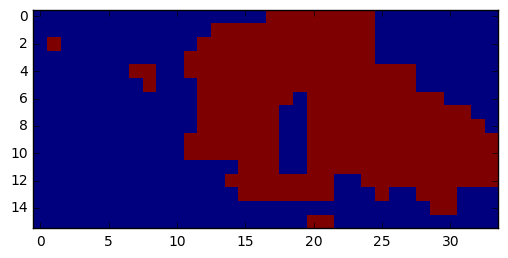

In [14]:
plt.imshow(b, interpolation='none')
plt.show()

In [15]:
def change_class(value, old, new):
    if value == old:
        return new
    else:
        return value
np_change_class = np.vectorize(change_class)




def stuff(mat,i,j,islands_list, count, islands_matrix):
    if mat[i][j] == 0:
        pass
    else:
        before = int(islands_matrix[i][j-1])
        above = int(islands_matrix[i-1][j])
        if before == 0:
            if  above== 0:
                islands_matrix[i][j] = count
                count +=1
                islands_list.append([(j,i)])
            else: 
                islands_matrix[i][j] = above
                islands_list[above-1].append((j,i))
        
        else:
            if above == 0:
                islands_matrix[i][j] = before
                islands_list[before-1].append((j,i))
            
            
            else:
                if above == before:
                    islands_matrix[i][j] = before
                    islands_list[before-1].append((j,i))
                
                #it's on.
                else:
                    old = max((above,before))
                    new = min((above,before))
                    
                    islands_matrix[i][j] = new
                    islands_matrix = np_change_class(islands_matrix, old, new)
                    islands_list[new-1] += islands_list[old-1]
                    islands_list[new-1].append((j,i))
                    islands_list[old-1] = []
                    
    return islands_list, count, islands_matrix        


# The not fun part
def group_by_island(matrix):
    
    h, l = np.shape(matrix)
    border = np.array([[0]*(l)])
    mat = np.concatenate((border,matrix), axis=0)
    border = np.array([[0]*(h+1)])
    mat = np.concatenate((border.T, mat), axis=1)
    
    islands_matrix =np.zeros((h+1,l+1))
    count = 1
    islands_list = []
    
    for i in range(1,h+1):
        for j in range(1, l+1):
            islands_list, count, islands_matrix = stuff(mat,i,j,islands_list, count, islands_matrix)

    
    
    return islands_matrix, islands_list
    

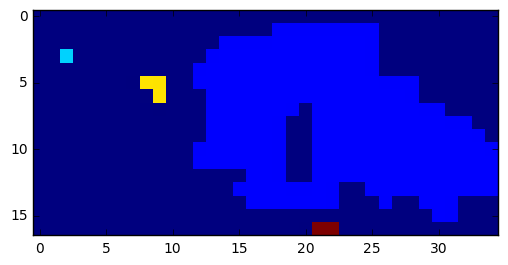

In [16]:
islands_matrix, islands_list = group_by_island(b)
plt.imshow(islands_matrix, interpolation='none')
plt.show()

In [17]:
def find_extremes(list_coordinates):
    max_x = max(list_coordinates, key = lambda x: x[0])[0]
    min_x = min(list_coordinates, key = lambda x: x[0])[0]
    max_y = max(list_coordinates, key = lambda x: x[1])[1]
    min_y = min(list_coordinates, key = lambda x: x[1])[1]
    
    #print(min_x, min_y, max_x, max_y )
    
    return min_x - 1, min_y - 1, max_x-min_x + 1, max_y-min_y + 1


def get_rectangles(islands_list, area_limit=4):
    list_coordinates = []
    for island in islands_list:
        if len(island) == 0:
            continue
        else:
            coordinates = find_extremes(island)
            #print(coordinates)
            #print(coordinates[2]*coordinates[3])
            if coordinates[2]*coordinates[3] >=area_limit:
                #print(coordinates)
                list_coordinates.append(coordinates)
            
    return list_coordinates
    

In [18]:
rectangles = get_rectangles(islands_list)

In [19]:
print(rectangles[0])

(11, 0, 23, 15)


In [20]:
def convert_coordinates(rectangles, heatmap, path_image):
    y, x = np.shape(heatmap)
    #print('y=' + str(y))
    #print("x=" + str(x))
    
    img = np.array(Image.open(path_image))
    y1, x1, channel = np.shape(img)
    #print("x1=" + str(x1))
    #print("y1=" + str(y1))
    
    ratio_x = x1/x
    ratio_y = y1/y
    
    converted_rectangles = []
    for r in rectangles:
        converted_rectangles.append((r[0]*ratio_x, r[1]*ratio_y, r[2]*ratio_x, r[3]*ratio_y,))
        
    return converted_rectangles

In [21]:
new_rectangles = convert_coordinates(rectangles, a, l[0])

In [22]:
new_dic = {"filename": l[0], "rectangles": new_rectangles}

In [23]:
new_dic

{'filename': './train/ALB\\img_00003.jpg',
 'rectangles': [(414.11764705882354, 0.0, 865.8823529411765, 675.0),
  (263.5294117647059, 180.0, 75.29411764705883, 90.0)]}

In [25]:
c=0.4
def from_pickle_to_rectangle(img_path, pickle_path):
    
    with open(pickle_path,"rb") as f:
        heatmap = pickle.load(f)
        
    # Here we will modify the heatmap, removing activation on the extremes of the image, because
    # cause the fish detector to activate too often for some reason.
    line_zeros = np.zeros(np.shape(heatmap)[0])
    column_zeros = np.zeros(np.shape(heatmap)[1])
    heatmap[:,0] = line_zeros
    heatmap[:,-1] = line_zeros
    heatmap[0,] = column_zeros
    heatmap[-1,:] = column_zeros
    
        
    #print(np.shape(heatmap))
    threshold = c*np.max(heatmap)
    binary_map = np_binarize(heatmap, threshold)
    islands_matrix, islands_list = group_by_island(binary_map)
    rectangles = get_rectangles(islands_list, area_limit=4)
    #print(rectangles[0])
    new_rectangles = convert_coordinates(rectangles, heatmap, img_path)
    #print(new_rectangles[0])
    new_dic = {"path": img_path, "rectangles": new_rectangles, "p_fish": np.max(heatmap)}
    
    
    return new_dic

In [26]:
list_rectangles_images = []
for i in tq(range(len(l))):
    dic = from_pickle_to_rectangle(l[i], dest_pickle[i])
    list_rectangles_images.append(dic)

In [25]:
import os
from fnmatch import fnmatch

l = []

root = './test_stg1/'
pattern = "*.jpg"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            l.append(os.path.join(path, name))

In [26]:
l[0]

'./test_stg1/img_00005.jpg'

In [27]:
s = 11
dest = [ string[:s] + "_heatmap" + string[s:] for string in l]
dest[0]

'./test_stg1_heatmap/img_00005.jpg'

In [28]:
dest_pickle = [string[:s] + "_pickle" + string[s:] for string in l]

In [29]:
#save_heatmaps(model,l,dest_pickle, dest)

In [42]:
list_rectangles_images = []
for i in tq(range(len(l))):
    dic = from_pickle_to_rectangle(l[i], dest_pickle[i])
    list_rectangles_images.append(dic)

In [31]:
with open("test_rectangles.p", "wb") as f:
    pickle.dump(list_rectangles_images,f)

In [34]:
my_list[0:5]

[{'p_fish': 0.75145096, 'path': './test_stg1/img_00005.jpg', 'rectangles': []},
 {'p_fish': 0.86994344,
  'path': './test_stg1/img_00007.jpg',
  'rectangles': [(675.0, 0.0, 675.0, 451.7647058823529)]},
 {'p_fish': 0.96823865,
  'path': './test_stg1/img_00009.jpg',
  'rectangles': [(360.0, 0.0, 1080.0, 263.5294117647059)]},
 {'p_fish': 0.77316874,
  'path': './test_stg1/img_00018.jpg',
  'rectangles': [(630.0, 0.0, 810.0, 338.8235294117647)]},
 {'p_fish': 0.56881583,
  'path': './test_stg1/img_00027.jpg',
  'rectangles': [(495.0, 301.1764705882353, 135.0, 112.94117647058823)]}]

In [ ]:
for i in range(50,70):
    dic = list_rectangles_images[i]
    img = Image.open(dic["path"])
    print(str(dic["p_fish"]*100) + "        " + dic["path"])
    plt.imshow(img)
    plt.show()
    
    with open(dest_pickle[i], "rb") as f:
        heatmap = pickle.load(f)
        
    
    line_zeros = np.zeros(np.shape(heatmap)[0])
    column_zeros = np.zeros(np.shape(heatmap)[1])
    heatmap[:,0] = line_zeros
    heatmap[:,-1] = line_zeros
    heatmap[0,] = column_zeros
    heatmap[-1,:] = column_zeros
        
    plt.imshow(heatmap, interpolation='none')
    plt.show()
    
    threshold = c*np.max(heatmap)
    binary_map = np_binarize(heatmap, threshold)
    
    plt.imshow(binary_map, interpolation='none')
    plt.show()
    
    for rec in dic["rectangles"]:
        print("fish found: " + str(rec))
        img2 = img.crop((rec[0],rec[1], rec[0] + rec[2], rec[1] + rec[3]))
        plt.imshow(img2)
        plt.show()

In [99]:
def get_sea_rectangle(predict):
    
    
    
    # We make the assumpption that the standart image size is 57x101
    # the order is x top left, y top left, x bottom right, y bottom right
    # This is the string order, not the numerical order! beware!
    if predict ==1:
        rectangle = [[58,0,100,56]]
    if predict ==10:
        rectangle = [[0,45,15,56]]
    if predict ==11:
        rectangle = [[80,0,100,56],[0,0,20,20]]
    if predict ==12:
        rectangle = [[0,0,20,56]]
    if predict ==13:
        rectangle = [[0,30,100,56]]
    if predict ==14:
        rectangle = [[85,0,100,56],[0,40,30,56]]
    if predict ==15:
        rectangle = [[0,0,100,15],[0,0,30,30]]
    if predict ==16:
        rectangle = [[0,0,10,56]]
    if predict ==17:
        rectangle = [[55,0,100,56]]
    if predict ==2:
        rectangle = [[50,0,100,56]]
    if predict ==3:
        rectangle = [[0,0,25,56]]
    if predict ==4:
        rectangle = [[0,0,100,15]]
    if predict ==5:
        rectangle = [[0,0,100,20],[65,0,100,56]]
    if predict ==6:
        rectangle = [[0,0,100,25],[0,0,20,56]]
    if predict ==7:
        rectangle = [[0,0,20,56],[75,0,100,20]]
    if predict ==8:
        rectangle = [[0,0,20,56]]
    if predict ==9:
        rectangle = [[80,0,100,56]]
    return rectangle
    

In [100]:
del model

In [101]:
model = load_model("cool_model_boats_id.h5")

In [102]:
def remove_patches(heatmap, rectangles):
    y_map, x_map = np.shape(heatmap)
    for rectangle in rectangles: 
        x_min = int(rectangle[0] *x_map/100)
        x_max = int(rectangle[2] *x_map/100)
        y_min = int(rectangle[1] *y_map/56)
        y_max = int(rectangle[3] *y_map/56)
        
        for i in range(y_map):
            for j in range(x_map):
                if y_min<=i<y_max and x_min<=j<x_max:
                    heatmap[i,j] = 0
                    
    return heatmap

In [112]:
def hide_sea(heatmap, img_path, treashold = 0.87):
    img = load_img(img_path,grayscale=True, target_size=(64,64))
    img = img_to_array(img)
    
    probabilities = model.predict(np.array([img,]))[0][1:]
    #print(probabilities)
    
    if np.max(probabilities) >= treashold:
        rectangles = get_sea_rectangle(np.argmax(probabilities) + 1)
        heatmap = remove_patches(heatmap, rectangles)
    
    return heatmap

In [113]:
c=0.4
def from_pickle_to_rectangle(img_path, pickle_path, plot=False):
    
    with open(pickle_path,"rb") as f:
        heatmap = pickle.load(f)
        
    # Here we will modify the heatmap, removing activation on the extremes of the image, because
    # cause the fish detector to activate too often for some reason.
    line_zeros = np.zeros(np.shape(heatmap)[0])
    column_zeros = np.zeros(np.shape(heatmap)[1])
    heatmap[:,0] = line_zeros
    heatmap[:,-1] = line_zeros
    heatmap[0,] = column_zeros
    heatmap[-1,:] = column_zeros
    
    if plot:
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()
        plt.imshow(heatmap, interpolation='none')
        plt.show()
    
    heatmap = hide_sea(heatmap, img_path)
    
    if plot:
        plt.imshow(heatmap, interpolation='none')
        plt.show()
        
    #print(np.shape(heatmap))
    threshold = c*np.max(heatmap)
    binary_map = np_binarize(heatmap, threshold)
    
    if plot:
        plt.imshow(binary_map, interpolation='none')
        plt.show()
    
    islands_matrix, islands_list = group_by_island(binary_map)
    rectangles = get_rectangles(islands_list, area_limit=4)
    new_rectangles = convert_coordinates(rectangles, heatmap, img_path)
    new_dic = {"path": img_path, "rectangles": new_rectangles, "p_fish": np.max(heatmap)}
    
    if plot:
        for rec in new_dic["rectangles"]:
            print("fish found: " + str(rec))
            img2 = img.crop((rec[0],rec[1], rec[0] + rec[2], rec[1] + rec[3]))
            plt.imshow(img2)
            plt.show()
    
    return new_dic

In [ ]:
list_rectangles_images = []
for i in tq(range(50,70)):
    dic = from_pickle_to_rectangle(l[i], dest_pickle[i], True)
    list_rectangles_images.append(dic)